In [1]:
import snap 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

from matplotlib.pyplot import loglog 

%matplotlib inline 

In [2]:
print(snap.Version)

6.0.0


In [3]:
df = pd.read_csv('out.dnc-temporalGraph.csv', header=None)

In [4]:
df.head(2)

,0,1,2,3
0,419,465,1,1463507482
1,869,453,1,1462337903


In [5]:
df.columns = ['src', 'dst', 'weight', 'timestamp']

In [6]:
df.head(2)

,src,dst,weight,timestamp
0,419,465,1,1463507482
1,869,453,1,1462337903


In [7]:
def ProcessEdgeRow(row, Graph):
    src = int(row['src'])
    dst = int(row['dst'])
    timestamp = row['timestamp']
    
    if not Graph.IsNode(src):
        Graph.AddNode(src)
    
    if not Graph.IsNode(dst):
        Graph.AddNode(dst)
        
    if not Graph.IsEdge(src, dst):
        EId = Graph.AddEdge(src, dst)   
    else:
        EId = Graph.GetEI(src, dst) 
    
    Graph.AddIntAttrDatE(EId, timestamp, 'timestamp')
        
    return

        

In [8]:
def GenerateDirectedGraph(df):
    #TNEANet là một lớp đồ thị có hỗ trợ các thuộc tính được gán cho các cạnh và nút,
    Graph = snap.TNEANet.New()
    df.apply(ProcessEdgeRow, axis=1, Graph=Graph)

    return Graph

In [9]:
G = GenerateDirectedGraph(df)

In [10]:
print("Nodes: ", G.GetNodes())
print("Edges: ", G.GetEdges())

Nodes:  1891
Edges:  5598


## Get Raw Statistics 

    1. Degree Centrality 
    2. Clustering Coefficient 
    3. Mean shortest path from each node 
    4. Betweeness Centralitily 
    5. Hub and Authority Score 

In [11]:
# Khởi tạo dictionary NodeAttributes
NodeAttributes = {}

#### Step 1: Degree Centrality

In [12]:
# Tính toán Indegree vs Outdegree
InDegV = snap.TIntPrV()
OutDegV = snap.TIntPrV()

snap.GetNodeOutDegV(G, OutDegV)
snap.GetNodeInDegV(G, InDegV)
# Lưu trữ các node và giá trị indegree tương ứng với từng node vào list InDegreeList
# Lưu trữ các node và giá trị outdegree tương ứng với từng node vào list OutDegreeList
InDegreeList = [ (item.GetVal1(), item.GetVal2()) for item in InDegV ]
OutDegreeList = [ (item.GetVal1(), item.GetVal2()) for item in OutDegV ]

In [13]:
# Sắp xếp list InDegreeList, OutDegreeList
InDegreeList.sort(key=lambda x: x[1], reverse=True)
OutDegreeList.sort(key=lambda x: x[1], reverse=True)
# Tìm giá trị min, max của OutDegree và InDegree
minOutDegree = min(OutDegreeList, key = lambda x: x[1])[1]
maxOutDegree = max(OutDegreeList, key = lambda x: x[1])[1]
minInDegree = min(InDegreeList, key = lambda x: x[1])[1]
maxInDegree = max(InDegreeList, key = lambda x: x[1])[1]

In [14]:
print(maxOutDegree, minOutDegree, maxInDegree, minInDegree)
print(InDegreeList[0], InDegreeList[-1])

331 0 249 0
(1874, 249) (893, 0)


In [15]:
for (nodeId, Degree) in InDegreeList:
    if not NodeAttributes.get(nodeId, None):
        NodeAttributes[nodeId] = {}
    NodeAttributes[nodeId]['InDegree'] = Degree
    normalizedDegree = (float(Degree) - float(minInDegree))/(float(maxInDegree - float(minInDegree)))
    NodeAttributes[nodeId]['NormInDegree'] = normalizedDegree

for (nodeId, Degree) in OutDegreeList: 
    NodeAttributes[nodeId]['OutDegree'] = Degree
    normalizedDegree = (float(Degree) - float(minOutDegree))/(float(maxOutDegree - float(minOutDegree)))
    NodeAttributes[nodeId]['NormOutDegree'] = normalizedDegree

In [16]:
print(NodeAttributes[1874])
print(NodeAttributes[893])

{'InDegree': 249, 'NormInDegree': 1.0, 'OutDegree': 331, 'NormOutDegree': 1.0}
{'InDegree': 0, 'NormInDegree': 0.0, 'OutDegree': 1, 'NormOutDegree': 0.0030211480362537764}


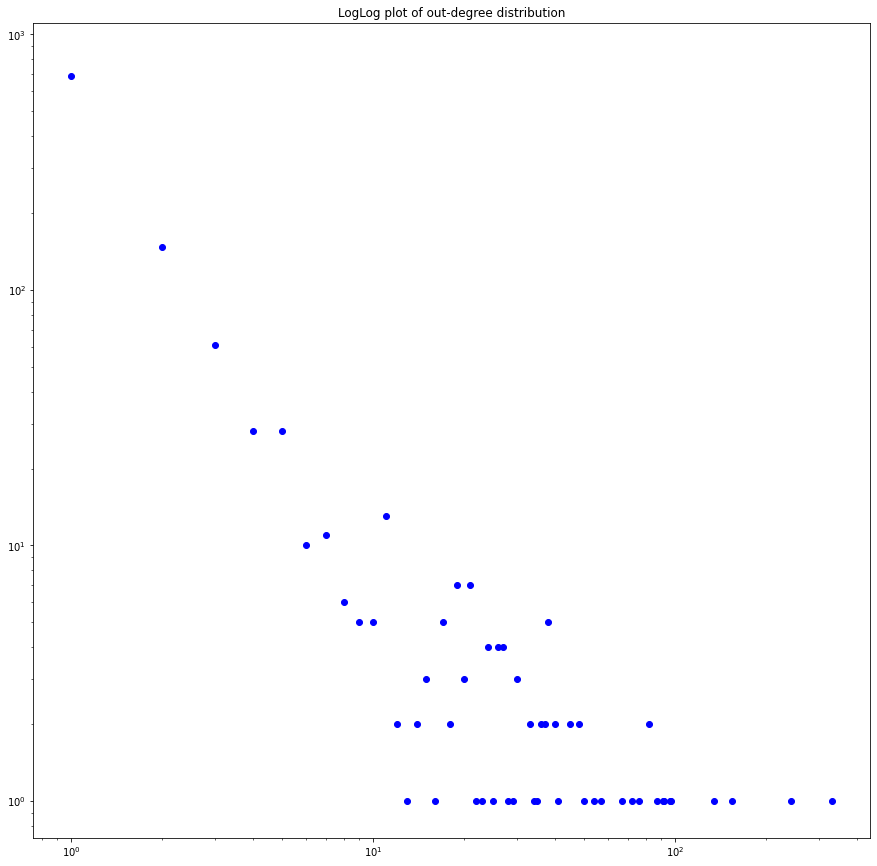

In [17]:
# Degree Distribution 

OutDegToCntV = snap.TIntPrV()
snap.GetOutDegCnt(G, OutDegToCntV)
count = 0
nodeList = []
degreeList = []
for item in OutDegToCntV:
    (n, d) = (item.GetVal2(), item.GetVal1())
    nodeList.append(n)
    degreeList.append(d)
x = np.array( [ np.log10(item.GetVal1()) for itemm in OutDegToCntV if item.GetVal1() > 0 ] )
y = np.array( [ np.log10(item.GetVal2()) for item in OutDegToCntV if item.GetVal2() > 0 ] )
# Plot Degree Distribution
plt.figure(figsize=(15,15))
loglog(degreeList, nodeList, 'bo')
plt.title("LogLog plot of out-degree distribution")
plt.show()

#### Step 2: Clustering Coefficient

In [18]:
NIdCCfH = snap.TIntFltH()
snap.GetNodeClustCf(G, NIdCCfH)
ClusterCoeffList = list()
for nodeId in NIdCCfH:
    NodeAttributes[nodeId]['ClusterCoeff'] = NIdCCfH[nodeId]
    ClusterCoeffList.append((nodeId, NIdCCfH[nodeId]))

In [19]:
ClusterCoeffList.sort(key=lambda x: x[1], reverse=True)
minClusterCoeff = min(ClusterCoeffList, key=lambda x: x[1])[1]
maxClusterCoeff = max(ClusterCoeffList, key=lambda x: x[1])[1]

In [20]:
print(ClusterCoeffList[1], maxClusterCoeff, ClusterCoeffList[-1], minClusterCoeff)

(1753, 1.0) 1.0 (1381, 0.0) 0.0


In [21]:
NIdCCfH = snap.TIntFltH()
snap.GetNodeClustCf(G, NIdCCfH)
ClusterCoeffList = list()
for nodeId in NIdCCfH:
    clusterCoeff = NIdCCfH[nodeId]
    normClusterCoeff = (clusterCoeff - minClusterCoeff)/(maxClusterCoeff - minClusterCoeff)
    NodeAttributes[nodeId]['NormClusterCoeff'] = normClusterCoeff

In [22]:
print(NodeAttributes[2012])

{'InDegree': 3, 'NormInDegree': 0.012048192771084338, 'OutDegree': 0, 'NormOutDegree': 0.0, 'ClusterCoeff': 0.6666666666666666, 'NormClusterCoeff': 0.6666666666666666}


#### Step 3: Avergate shortest path length

In [23]:
nodeCount = float(G.GetNodes() - 1)
avgShortPathLenList = list()
for src in G.Nodes():
    srcId = src.GetId()
    totalShortPathLength = 0 
    
    for dst in G.Nodes():
        dstId = dst.GetId()
        if srcId == dstId:
            continue
        l = snap.GetShortPath(G, srcId, dstId, True)
        if l < 0:
            continue
            
        totalShortPathLength += float(l) 
    NodeAttributes[srcId]['AvgShortPathLen'] = totalShortPathLength/nodeCount
    avgShortPathLenList.append((srcId, totalShortPathLength/nodeCount))

In [24]:
minAvgShortPathLength = min(avgShortPathLenList, key=lambda x: x[1])[1]
maxAvgShortPathLength = max(avgShortPathLenList, key=lambda x: x[1])[1]

In [25]:
for (node, spLen) in avgShortPathLenList:
    normAvgShortPath = (spLen - minAvgShortPathLength)/(maxAvgShortPathLength - minAvgShortPathLength)
    NodeAttributes[node]['normAvgShortPathLen'] = normAvgShortPath

In [26]:
print(NodeAttributes[480])

{'InDegree': 2, 'NormInDegree': 0.008032128514056224, 'OutDegree': 1, 'NormOutDegree': 0.0030211480362537764, 'ClusterCoeff': 0.3333333333333333, 'NormClusterCoeff': 0.3333333333333333, 'AvgShortPathLen': 4.321164021164021, 'normAvgShortPathLen': 1.0}


#### Step 4: Betweeness Centrality

In [27]:
Nodes = snap.TIntFltH()
Edges = snap.TIntPrFltH()
BetweenessNodeList = list()
BetweenessEdgeList = list()

snap.GetBetweennessCentr(G, Nodes, Edges, 1.0)
for node in Nodes:
    NodeAttributes[node]['Betweeness'] = Nodes[node]
    BetweenessNodeList.append((node, Nodes[node]))

for edge in Edges:
    BetweenessEdgeList.append((edge.GetVal1(), edge.GetVal2(), Edges[edge]))

BetweenessNodeList.sort(key=lambda x: x[1], reverse=True) 
BetweenessEdgeList.sort(key=lambda x: x[2], reverse=True)

In [28]:
print(BetweenessNodeList[0], BetweenessNodeList[-1])

(1669, 556845.3564806876) (884, 0.0)


In [29]:
minBetweeness = BetweenessNodeList[-1][1]
maxBetweeness = BetweenessNodeList[0][1]
for (node, betweeness) in BetweenessNodeList:
    normBetweeness = (betweeness - minBetweeness)/(maxBetweeness - minBetweeness)
    NodeAttributes[node]['normBetweeness'] = normBetweeness   

In [30]:
print(NodeAttributes[1669])
print(NodeAttributes[884])

{'InDegree': 222, 'NormInDegree': 0.891566265060241, 'OutDegree': 242, 'NormOutDegree': 0.7311178247734139, 'ClusterCoeff': 0.0007700181235972993, 'NormClusterCoeff': 0.0007700181235972993, 'AvgShortPathLen': 1.439153439153439, 'normAvgShortPathLen': 0.33304763070895066, 'Betweeness': 556845.3564806876, 'normBetweeness': 1.0}
{'InDegree': 1, 'NormInDegree': 0.004016064257028112, 'OutDegree': 0, 'NormOutDegree': 0.0, 'ClusterCoeff': 0.0, 'NormClusterCoeff': 0.0, 'AvgShortPathLen': 0.0, 'normAvgShortPathLen': 0.0, 'Betweeness': 0.0, 'normBetweeness': 0.0}


#### Step 5: Get Auth and Hub Score

In [31]:
NIdHubH = snap.TIntFltH()
NIdAuthH = snap.TIntFltH()
snap.GetHits(G, NIdHubH, NIdAuthH)
HubNodes = []
for nodeId in  NIdHubH:
    HubNodes.append((nodeId,  NIdHubH[nodeId]))
    NodeAttributes[nodeId]['HubScore'] = NIdHubH[nodeId]
    
HubNodes.sort(key = lambda x: x[1], reverse=True)

AuthNodes = []
for nodeId in  NIdAuthH:
    AuthNodes.append((nodeId,  NIdAuthH[nodeId])) 
    NodeAttributes[nodeId]['AuthScore'] = NIdAuthH[nodeId]
AuthNodes.sort(key = lambda x: x[1], reverse=True)


In [32]:
print(AuthNodes[0], AuthNodes[-1])
print(HubNodes[0], HubNodes[-1])

(1874, 0.30510831720503034) (893, 0.0)
(1874, 0.38410704002084095) (884, 0.0)


In [33]:
minAuthNodes = AuthNodes[-1][1]
maxAuthNodes = AuthNodes[0][1]
minHubNodes = HubNodes[-1][1]
maxHubNodes = HubNodes[0][1]

In [34]:
for (node, hubScore) in HubNodes:
    normHubScore = (hubScore - minHubNodes)/(maxHubNodes - minHubNodes)
    NodeAttributes[node]['normHubScore'] = normHubScore
    
for (node, authScore) in AuthNodes:
    normAuthScore = (authScore - minAuthNodes)/(maxAuthNodes - minAuthNodes)
    NodeAttributes[node]['normAuthScore'] = normAuthScore

In [35]:
print(NodeAttributes[1874])
print(NodeAttributes[893])

{'InDegree': 249, 'NormInDegree': 1.0, 'OutDegree': 331, 'NormOutDegree': 1.0, 'ClusterCoeff': 0.0014452513597956258, 'NormClusterCoeff': 0.0014452513597956258, 'AvgShortPathLen': 1.456084656084656, 'normAvgShortPathLen': 0.33696583812905595, 'Betweeness': 495085.4708108281, 'normBetweeness': 0.8890896997683746, 'HubScore': 0.38410704002084095, 'AuthScore': 0.30510831720503034, 'normHubScore': 1.0, 'normAuthScore': 1.0}
{'InDegree': 0, 'NormInDegree': 0.0, 'OutDegree': 1, 'NormOutDegree': 0.0030211480362537764, 'ClusterCoeff': 0.0, 'NormClusterCoeff': 0.0, 'AvgShortPathLen': 0.0005291005291005291, 'normAvgShortPathLen': 0.0001224439818782907, 'Betweeness': 0.0, 'normBetweeness': 0.0, 'HubScore': 0.00018503722141871546, 'AuthScore': 0.0, 'normHubScore': 0.00048173348087729835, 'normAuthScore': 0.0}


## Automatic Social Hierarchy Detection From Email Network 

### Steps 

    1. Compute node's importance on response time for email  
    2. Get all Cliques (Algorithm 457)
    3. Number of clique each node is part of 
    4. Raw Clique Score computed using 
    
 $$R*2^{n-1}$$
 
    5. Weighted Clique Score (Based on importance of a person) 
    
 $$W = t*2^{n-1}$$
 

### Use networkx library for Clique analysis 

    1. Build a multigraph with edges for each (src, dst, timestamp) entry in the email data set 
    2. Build undirected graph with edges between nodes only when email count exceeds N=4 between two those nodes 
    

In [36]:
def ProcessNxEdgeRow(row, Graph):
    src = row['src']
    dst = row['dst']
    timestamp = row['timestamp']
    
    Graph.add_node(src)
    Graph.add_node(dst)
    Graph.add_edge(src, dst, timestamp=timestamp)
        
    return
        

In [37]:
def GenerateDirectedNxGraph(df):
    Graph = nx.MultiDiGraph(name="DNC Email Network")
    df.apply(ProcessNxEdgeRow, axis=1, Graph=Graph)

    return Graph

In [38]:
GNx = GenerateDirectedNxGraph(df)

In [39]:
print("Networkx Nodes: ", GNx.number_of_nodes())
print("Networkx Edges: ", GNx.number_of_edges())

Networkx Nodes:  1891
Networkx Edges:  39264


#### Prune all edges with N <=4 emails exchanged
As per the paper - consider edges between nodes only if the nodes have exchanged > N messages
N is a tunable parameter 

DNC email has a median of message exchanged = 2 

In [40]:
edgeCount = dict()
for edge in GNx.edges():
    if not edgeCount.get(edge, None):
        edgeCount[edge] = 0
    edgeCount[edge] += 1      

In [41]:
emailDist= [v for k, v in edgeCount.items()]
emailDist.sort(reverse=True)

In [42]:
print(emailDist[0], emailDist[-1], np.median(emailDist), len(emailDist))

731 1 2.0 5598


In [43]:
N = 4
pruneList = [ k for k, v in edgeCount.items() if v <= N ]
prunedEdgeList = [ k for k, v in edgeCount.items() if v > N ]

### Generate undirected graph with edges between nodes with email count > N

In [44]:
uGNx = nx.Graph()

for edge in prunedEdgeList:
    (src, dst) = edge
    uGNx.add_edge(src, dst)
    
print("Networkx Nodes: ", uGNx.number_of_nodes())
print("Networkx Edges: ", uGNx.number_of_edges())

Networkx Nodes:  452
Networkx Edges:  1139


### Step 1: Compute Nodes importance on email response time 

### Approach 1: Based on Rowe et. al. paper 

Use response time to measure importance of a node 

    1. For each node get all the out bound email timestamps 
    2. For each email sent - check the response time from the receiver 
    3. Consider responses within a day for computing time score. 
    4. Consider response time for nodes that have exchanged at least 100 emails 
       (fewer emails with high response time can falsely promote node based on time score)
 

In [45]:
temporalMap = dict()
for n, nbrs in GNx.adjacency():
    temporalMap[n] = {}
    for nbr, edict in nbrs.items():
        t1 = [d['timestamp'] for d in edict.values()]
        t1.sort()
        temporalMap[n][nbr] = t1 

In [46]:
from datetime import datetime, timezone

avgNodeResponse = list()

for src, destinations in temporalMap.items():
    totalRequestResp = 0
    totalResponseTime = 0.0
    
    for dst, reqTimestamps in destinations.items():
        responseTime = None

        for req in reqTimestamps:
            reqTime = datetime.fromtimestamp(req)

            for resp in temporalMap[dst].get(src, list()):
                respTime = datetime.fromtimestamp(resp)
            
                if resp < req:

                    continue
            
                deltaTime = respTime - reqTime
            
                if deltaTime.total_seconds() > 86400:

                    break
                
                totalRequestResp += 1
                totalResponseTime += deltaTime.total_seconds()
                break

    if totalRequestResp > 0 and totalResponseTime > 0:
        avgResponse = totalResponseTime/totalRequestResp
    else:
        avgResponse = float(7*86400)
    timeScore = 1/avgResponse
    avgNodeResponse.append((src, timeScore, totalResponseTime, totalRequestResp ))
        

In [47]:
avgNodeTimeScore = list()

#
# Ignore response time for email exchanges fewer than 10
#
for x in avgNodeResponse:
    (src, timeScore, totalResponseTime, totalRequestResp) = x
    
    if totalRequestResp <= 200:
        timeScore = 1.0/float(7*86400)
        
    avgNodeTimeScore.append((src, timeScore, totalResponseTime, totalRequestResp))
        
avgNodeTimeScore.sort(key=lambda x: x[1], reverse=True)


In [48]:
print(avgNodeTimeScore[-1])
print(avgNodeTimeScore[:2])

(884, 1.6534391534391535e-06, 0.0, 0)
[(1625, 0.0020221266801294163, 368424.0, 745), (895, 0.00011885108532413246, 1918367.0, 228)]


In [49]:
print(NodeAttributes[1625])

{'InDegree': 7, 'NormInDegree': 0.028112449799196786, 'OutDegree': 10, 'NormOutDegree': 0.030211480362537766, 'ClusterCoeff': 0.05714285714285714, 'NormClusterCoeff': 0.05714285714285714, 'AvgShortPathLen': 1.9407407407407407, 'normAvgShortPathLen': 0.4491245255295702, 'Betweeness': 4076.0655300534095, 'normBetweeness': 0.007319923714214854, 'HubScore': 0.037001447460587755, 'AuthScore': 0.036908751066446865, 'normHubScore': 0.09633108380044303, 'normAuthScore': 0.12096933772423019}


In [50]:
normTimeScore = {}
minAvgTimeScore = avgNodeTimeScore[-1][1]
maxAvgTimeScore = avgNodeTimeScore[0][1]

for (node, timeScore, _, _) in avgNodeTimeScore:
    normTimeScore[node] = (timeScore - minAvgTimeScore)/(maxAvgTimeScore - minAvgTimeScore)

In [51]:
normTimeScore[1625]

1.0

In [52]:
nodeCliqueCount = {}
rawCliqueScore = {}
weightedCliqueScore = {}

for clique in nx.find_cliques(uGNx):
    for node in clique:
        
        if not nodeCliqueCount.get(node, None):
            nodeCliqueCount[node] = 0
            
        if not rawCliqueScore.get(node, None):
            rawCliqueScore[node] = 0
        
        if not weightedCliqueScore.get(node, None):
            weightedCliqueScore[node] = 0
            
        nodeCliqueCount[node] += 1 
        
        n = len(clique)
        
        rawCliqueScore[node] += 2**n
        
        weightedCliqueScore[node] += (2**n)*normTimeScore[node]

In [53]:
nodeCliqueList = [ (k, v) for k, v in nodeCliqueCount.items() ]
nodeCliqueList.sort(key=lambda x: x[1], reverse=True )

In [54]:
rawCliqueList = [ (k, v) for k, v in rawCliqueScore.items() ]
rawCliqueList.sort(key=lambda x: x[1], reverse=True )

In [55]:
weightedCliqueList = [ (k, v) for k, v in weightedCliqueScore.items() ]
weightedCliqueList.sort(key=lambda x: x[1], reverse=True )

In [56]:
print(nodeCliqueList[:10])
print(rawCliqueList[:10])
print(weightedCliqueList[:10])

[(1874, 157), (1839, 123), (1669, 104), (999, 79), (1258, 79), (1369, 76), (453, 75), (585, 66), (1144, 57), (1159, 46)]
[(1874, 29604), (999, 27636), (1258, 27616), (511, 22656), (1369, 21044), (1974, 18560), (1998, 18416), (585, 17972), (1144, 12248), (1899, 10304)]
[(1258, 1133.2113553681543), (1874, 1079.9719124532426), (999, 887.6525051646299), (511, 671.973655462151), (1998, 455.752744276308), (585, 335.7248913932537), (1669, 246.35443082589936), (1440, 223.60144658592768), (1287, 134.03972467188618), (453, 98.8985963334423)]


In [57]:
minNodeCliqueCount = nodeCliqueList[-1][1]
maxNodeCliqueCount = nodeCliqueList[0][1]

minRawCliqueScore = rawCliqueList[-1][1]
maxRawCliqueScore = rawCliqueList[0][1]

minWeightedCliqueScore = weightedCliqueList[-1][1]
maxWeightedCliqueScore = weightedCliqueList[0][1]

In [58]:
for node, score in nodeCliqueList:
    NodeAttributes[node]['nodeClique'] = score
    NodeAttributes[node]['normNodeClique'] = float(score - minNodeCliqueCount)/float(maxNodeCliqueCount - minNodeCliqueCount)

In [59]:
for node, score in rawCliqueList:
    NodeAttributes[node]['rawClique'] = score
    NodeAttributes[node]['normRawClique'] = float(score - minRawCliqueScore)/float(maxRawCliqueScore - minRawCliqueScore)

In [60]:
for node, score in weightedCliqueList:
    NodeAttributes[node]['weigthedClique'] = score
    NodeAttributes[node]['normWeightedClique'] = float(score - minWeightedCliqueScore)/float(maxWeightedCliqueScore - minWeightedCliqueScore)

In [61]:
NodeAttributes[1874]

{'InDegree': 249,
 'NormInDegree': 1.0,
 'OutDegree': 331,
 'NormOutDegree': 1.0,
 'ClusterCoeff': 0.0014452513597956258,
 'NormClusterCoeff': 0.0014452513597956258,
 'AvgShortPathLen': 1.456084656084656,
 'normAvgShortPathLen': 0.33696583812905595,
 'Betweeness': 495085.4708108281,
 'normBetweeness': 0.8890896997683746,
 'HubScore': 0.38410704002084095,
 'AuthScore': 0.30510831720503034,
 'normHubScore': 1.0,
 'normAuthScore': 1.0,
 'nodeClique': 157,
 'normNodeClique': 1.0,
 'rawClique': 29604,
 'normRawClique': 1.0,
 'weigthedClique': 1079.9719124532426,
 'normWeightedClique': 0.9530189645005671}

In [104]:
socialscorefeature = list()
for node, attributes in NodeAttributes.items():
    normNodeClique = attributes.get('normNodeClique')
    normRawClique = attributes.get('normRawClique')
    normWeightedClique = attributes.get('normWeightedClique')
    nodeClique = attributes.get('nodeClique')
    rawClique = attributes.get('rawClique')
    weigthedClique = attributes.get('weigthedClique')
    if (normNodeClique == None):
        normNodeClique = 0.0
    if (normRawClique == None):
        normRawClique = 0.0
    if (normWeightedClique == None):
        normWeightedClique = 0.0
    if (nodeClique == None):
        nodeClique = 0.0
    if (rawClique == None):
        rawClique = 0.0
    if (weigthedClique == None):
        weigthedClique = 0.0
    socialscorefeature.append((node, normNodeClique, normRawClique, normWeightedClique, nodeClique, rawClique, weigthedClique))

In [108]:
sort_socialscorefeature = sorted(socialscorefeature, key=lambda x: x[0])

print(sort_socialscorefeature)

[(1, 0.12179487179487179, 0.003986217147490034, 0.0, 20, 120, 0.0), (2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (5, 0.0, 6.756300249983109e-05, 0.0, 1, 4, 0.0), (6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (10, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (11, 0.0, 6.756300249983109e-05, 0.0, 1, 4, 0.0), (12, 0.00641025641025641, 0.0020944530774947637, 0.0, 2, 64, 0.0), (13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (14, 0.0, 6.756300249983109e-05, 0.0, 1, 4, 0.0), (15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (17, 0.0, 6.756300249983109e-05, 0.0, 1, 4, 0.0), (19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (20, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (21, 0.019230769230769232, 0.06911695155732721, 0.0, 4, 2048, 0.0), (22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (24, 0.00641025641025641, 0.00033781501249915546, 0.0, 2, 12, 0.0), (25, 0.01282051282051282, 0.0031

In [111]:
with open('nodeSocialScoreFeature.txt', 'w') as fd:
    for (node, normNodeClique, normRawClique, normWeightedClique, nodeClique, rawClique, weigthedClique) in sort_socialscorefeature:
        fd.write("%r %r %r %r %r %r %r\n" % (node, normNodeClique, normRawClique, normWeightedClique, nodeClique, rawClique, weigthedClique))

## Compute Weighted Social Score 

In [62]:
#
# Weights:
#
# W = [ Weighted Clique, RawClique, NumClique, OutDegree, InDegree, Cluster Coeff, Betweeness, Avg ShortPath, Auth, Hub]
#
w_weightedClique = 0.9
w_rawClique = 0.8
w_numClique = 0.7
w_outDegree = 0.6
w_inDegree = 0.6
w_clusterCoeff = 0.3 
w_betweeness = 0.3 
w_shortpath = 0.5 
w_auth = 0.2 
w_hub = 0.1 

w = np.array([w_weightedClique,\
             w_rawClique, \
             w_numClique, \
             w_outDegree, \
             w_inDegree, \
             w_clusterCoeff, \
             w_betweeness, \
             w_shortpath, \
             w_auth, \
             w_hub])

w_sum = np.sum(w)

### Social Score is computed as follows 

\begin{align}
w_x * C_x & = w_x * 100 * \left[ \frac{x_i - infx}{sup\ x - inf\ x} \right] \\
\\
score & = \frac{\Sigma_{all\ x} w * C_x}{\Sigma_{all\ x} w}
\end{align}

In [63]:
socialScore = list()

for node, attributes in NodeAttributes.items():
    weightedClique = attributes.get('normWeightedClique', 0.0)
    rawClique = attributes.get('normRawClique', 0.0)
    numClique = attributes.get('normNodeClique', 0.0)
    outDeg =  attributes.get('NormOutDegree', 0.0)
    inDeg =  attributes.get('NormInDegree', 0.0)
    clusterCoeff =  attributes.get('NormClusterCoeff', 0.0)
    betweeness = attributes.get('normBetweeness', 0.0)
    shortestPath = attributes.get('normAvgShortPathLen', 0.0)
    authScore = attributes.get('normAuthScore', 0.0)
    hubSccore = attributes.get('normHubScore', 0.0)
    
    C_x = np.array([weightedClique, \
                   rawClique, \
                   numClique, \
                   outDeg, \
                   inDeg, \
                   clusterCoeff, \
                   betweeness, \
                   shortestPath, \
                   authScore, \
                   hubSccore])
    
    score = 100.0 * np.dot(w, C_x)/w_sum
    socialScore.append((node, score))
    

In [64]:
socialScore.sort(key=lambda x: x[1], reverse=True)

In [66]:
print(socialScore[:10])

[(1874, 85.86720944906979), (1258, 55.9778907924103), (999, 50.61051396942535), (1669, 47.27542700847994), (511, 40.31705218340864), (585, 33.064089627423826), (1998, 32.41884981873541), (1839, 28.873591736745578), (1369, 28.7430390082418), (453, 28.201871267917863)]


In [67]:
with open('socialScore.txt', 'w') as fd:
    for (node, score) in socialScore:
        fd.write("%r  %r\n" % (node, score))